In [1]:
using Base: @kwdef
using Parameters: @unpack
using PyPlot

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278
┌ Info: Installing matplotlib via the Conda matplotlib package...
└ @ PyCall /Users/yukihiro-su/.julia/packages/PyCall/BD546/src/PyCall.jl:711
┌ Info: Running `conda install -y matplotlib` in root environment
└ @ Conda /Users/yukihiro-su/.julia/packages/Conda/x5ml4/src/Conda.jl:115


Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/yukihiro-su/.julia/conda/3

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cycler-0.10.0              |           py38_0          14 KB
    freetype-2.10.4            |       ha233b18_0         564 KB
    jpeg-9b                    |       he5867d9_2         201 KB
    kiwisolver-1.3.1           |   py38h23ab428_0          52 KB
    lcms2-2.12                 |       hf1fd2bf_0         284 KB
    libpng-1.6.37              |       ha441bb4_0         262 KB
    libtiff-4.1.0              |       hcb84e12_1         405 KB
    lz4-c-1.9.3                |       h23ab428_0         140 KB
    matplotlib-3.3.4           |   py38hecd8cb5_0          26 KB
    matplotlib-base-3.3.4      |   py38h8b3ea08_0         5.1 MB
    olefile-0.46               |          

┌ Info: Installing pyqt package to avoid buggy tkagg backend.
└ @ PyPlot /Users/yukihiro-su/.julia/packages/PyPlot/XHEG0/src/init.jl:118
┌ Info: Installing PyQt5 via the Conda pyqt package...
└ @ PyCall /Users/yukihiro-su/.julia/packages/PyCall/BD546/src/PyCall.jl:711
┌ Info: Running `conda install -y pyqt` in root environment
└ @ Conda /Users/yukihiro-su/.julia/packages/Conda/x5ml4/src/Conda.jl:115


Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/yukihiro-su/.julia/conda/3

  added / updated specs:
    - pyqt


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    dbus-1.13.18               |       h18a8e69_0         445 KB
    expat-2.3.0                |       h23ab428_2         113 KB
    gettext-0.21.0             |       h7535e17_0         2.6 MB
    glib-2.68.2                |       hdf23fa2_0         2.7 MB
    icu-58.2                   |       h0a44026_3        10.1 MB
    libiconv-1.16              |       h1de35cc_0         693 KB
    libxml2-2.9.10             |       h7cdb67c_3         1.1 MB
    llvm-openmp-10.0.0         |       h28b9765_0         236 KB
    pcre-8.44                  |       hb1e8313_0         185 KB
    pyqt-5.9.2                 |   py38h655552a_2         3.6 MB
    qt-5.9.7                   |       h468cd18_

In [2]:
@kwdef struct IZParameter{FT}
    C::FT = 100
    a::FT = 0.03
    b::FT = -2
    d::FT = 100
    k::FT = 0.7
    vthr::FT = -40
    vrest::FT = -60
    vreset::FT = -50
    vpeak::FT = 35
end

@kwdef mutable struct IZ{FT}
    param::IZParameter = IZParameter{FT}()
    N::UInt32
    v::Vector{FT} = fill(param.vrest, N)
    u::Vector{FT} = zeros(N)
    fire::Vector{Bool} = zeros(Bool, N)
end

Juliaでは慣用的に関数名の最後に!を付与したものは、引数の全てまたは一部を変更あるいは破棄することを示す。mutableなコレクションでは、コレクションに要素を追加したり削除する機能が提供されているので、それらを行う関数名の末尾には!がついている

In [3]:
function update!(variable::IZ, param::IZParameter, Ie::Vector, dt)
    @unpack N, v, u, fire = variable
    @unpack C, a, b, d, k, vthr, vrest, vreset, vpeak = param
    @inbounds for i = 1:N
        v[i] += dt/C * (k*(v[i]-vrest)*(v[i]-vthr) - u[i] + Ie[i])
        u[i] += dt * (a * (b * (v[i]-vrest) - u[i]))
    end
    @inbounds for i = 1:N
        fire[i] = v[i] >= vpeak
        v[i] = ifelse(fire[i], vreset, v[i])
        u[i] += ifelse(fire[i], d, 0)
    end
end;

In [4]:
T = 450 # ms
dt = 0.01f0 # ms
nt = UInt32(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
Ie = repeat(150f0 * ((t .> 50) - (t .> 200)) + 300f0 * ((t .> 250) - (t .> 400)), 1, N)  # injection current

# 記録用
varr, uarr = zeros(Float32, nt, N), zeros(Float32, nt, N)

# modelの定義
neurons = IZ{Float32}(N=N)

# simulation
@time for i = 1:nt
    update!(neurons, neurons.param, Ie[i, :], dt)
    varr[i, :], uarr[i, :] = neurons.v, neurons.u
end

  0.095236 seconds (819.24 k allocations: 25.692 MiB)


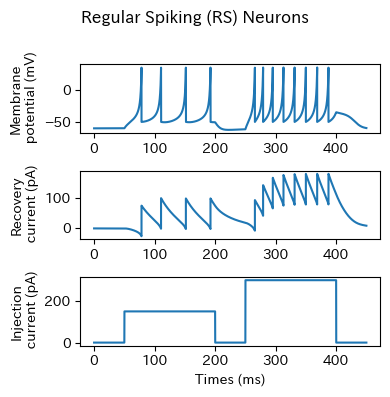

In [5]:
figure(figsize=(4, 4))
suptitle("Regular Spiking (RS) Neurons")
subplot(3,1,1); plot(t, varr[:, 1]); ylabel("Membrane\n potential (mV)")
subplot(3,1,2); plot(t, uarr[:, 1]); ylabel("Recovery\n current (pA)")
subplot(3,1,3); plot(t, Ie[:, 1]); ylabel("Injection\n current (pA)"); xlabel("Times (ms)")
tight_layout(rect=[0,0,1,0.96])

In [6]:
# 記録用
varr_ib, varr_ch = zeros(Float32, nt, N), zeros(Float32, nt, N)
Ie = repeat(500f0 * ((t .> 50) - (t .> 200)) + 700f0 * ((t .> 250) - (t .> 400)), 1, N)  # injection current

# IB neurons
neurons_ib = IZ{Float32}(N=N, 
    param=IZParameter{Float32}(C = 150, a = 0.01, b = 5, k =1.2, d = 130, vrest = -75, vreset = -56, vthr = -45, vpeak = 50))

# CH neurons
neurons_ch = IZ{Float32}(N=N, 
    param=IZParameter{Float32}(C = 50, a = 0.03, b = 1, k =1.5, d = 150, vrest = -60, vreset = -40, vthr = -40, vpeak = 35))

# simulation
@time for i = 1:nt
    update!(neurons_ib, neurons_ib.param, Ie[i, :], dt)
    update!(neurons_ch, neurons_ch.param, Ie[i, :], dt)
    varr_ib[i, :], varr_ch[i, :] = neurons_ib.v, neurons_ch.v
end

  0.055974 seconds (759.89 k allocations: 19.148 MiB, 11.77% gc time)


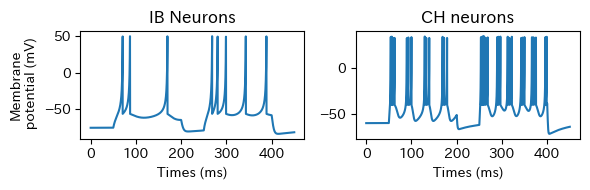

In [7]:
figure(figsize=(6, 2))
subplot(1,2,1); plot(t, varr_ib[:, 1]); title("IB Neurons"); ylabel("Membrane\n potential (mV)");  xlabel("Times (ms)")
subplot(1,2,2); plot(t, varr_ch[:, 1]); title("CH neurons"); xlabel("Times (ms)")
tight_layout()

以下の三項演算子は、

a ? b : c
普通にif文を使って書くと、

if a
    b
else
    c
end
みたいな感じになります。aが条件になっていて、trueのときにbを、falseのときにcを返します。

下記のモデル自体は**pulse-coupled neural networks(PCNN)**に基づかれており、神経間のシナプス結合の重みは行列Sで与えられて、j番目の神経の発火は自発的にSの要素によって変数vを変化させる

結果から分かることとして、ネットワークは皮質のような非対称性の挙動を示している。つまり、神経はポワソン型のスパイク訓練を行なっていて、その発火率は8Hzほどである。合成発火の挙動としては、最初はalpha rhythm(10Hz)でその後にgamma rhythm(40Hz)に変化する。

**ネットワークはランダムに接続されており、シナプス可塑性はない**けれども、神経の集合体への自己組織は集合的なリズム行動をとっていて、これらは哺乳類のawake状態を支持している。そして、シナプス結合の相対的な強さや視床駆動の強さが異なるタイプの集団行動を生み出している可能性がある。

このモデルニューラルネットの生物学的な妥当性と計算効率については、矛盾はないと主張されている。

In [38]:
# Excitatory neurons, Inhibitory neurons
Ne, Ni = 800, 200;
re, ri = rand(Ne,1), rand(Ni,1)
a = [0.02ones(Ne,1); 0.02 .+ 0.08ri]
b = [0.2ones(Ne,1); 0.25 .- 0.05ri]
c = [-65 .+ 15re.^2; -65ones(Ni,1)]
d = [8 .- 6re.^2; 2ones(Ni,1)]
S = [0.5rand(Ne+Ni,Ne) -rand(Ne+Ni,Ni)] # synaptic weight
v = -65ones(Ne+Ni,1)   # Initial values of v
u = b .* v              # Initial values of u
firings = []            # spike timings

for t=1:1000 # simulation of 1000 ms
    Ie = [5randn(Ne,1); 2randn(Ni,1)] # thalamic input
    fired = findall(v[:, 1] .>= 30) # indices of spikes
    firings = t==1 ? [t .+ 0*fired fired] : [firings; [t .+ 0*fired fired]]
    v[fired] = c[fired]
    u[fired] += d[fired]
    # 発火した神経のインデックスを全ての神経に足し算して和をとって伝えているイメージ
    Ie += sum(S[:,fired], dims=2)
    v += 0.5(0.04v.^2 + 5v .+140 - u + Ie) # step 0.5 ms for numerical stability
    v += 0.5(0.04v.^2 + 5v .+140 - u + Ie) 
    u += a .* (b .* v - u)
end

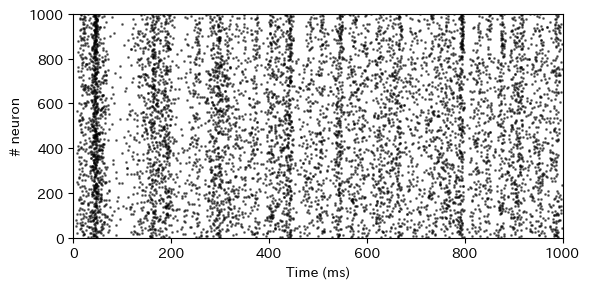

In [39]:
figure(figsize=(6, 3))
scatter(firings[:,1], firings[:,2], c="k", s=1, alpha=0.5)
xlabel("Time (ms)"); ylabel("# neuron"); xlim(0, 1000); ylim(0, 1000)
tight_layout()

### お試しというか復習

In [18]:
re = rand(3,3)
re

3×3 Array{Float64,2}:
 0.452228  0.886554  0.152261
 0.90579   0.968558  0.920404
 0.87471   0.27714   0.738221

In [41]:
v = rand(30,1)
fired = findall(v[:, 1] .>= 0.8)
fired

5-element Array{Int64,1}:
  4
  9
 13
 22
 28

In [53]:
A = collect(reshape(1:16, 4, 4))

4×4 Array{Int64,2}:
 1  5   9  13
 2  6  10  14
 3  7  11  15
 4  8  12  16

In [54]:
sum(A[:,[1,2]], dims=2)

4×1 Array{Int64,2}:
  6
  8
 10
 12

In [42]:
S = [rand(20,30); rand(10,30)]
S = rand(30,30)
sum(S[:,fired], dims=2)

30×1 Array{Float64,2}:
 2.85077663969399
 1.698704006567355
 2.0896187115660103
 2.706246596679328
 2.9026873759683465
 2.5054728674291433
 2.1072093362262265
 2.9383840132749253
 2.0900689628493017
 1.5890935047029473
 3.6429384891414314
 1.7967290625990007
 1.7440419965957956
 ⋮
 2.336356258090171
 3.447164139171721
 2.090432430281295
 2.6087218204447407
 2.7260177458571784
 2.1428021688111523
 1.8042657812594305
 3.0261027513674335
 2.7076495606160274
 2.0062388643739504
 1.4463037667508991
 2.1563297202387104